In [3]:
import numpy as np
from matplotlib import pyplot as plt
# import epics
import time
from time import localtime, strftime
from scipy.ndimage import rotate
import sys
import h5py
from optlnls.math import get_fwhm
from optlnls.plot import plot_xy
import random


# List of necessary PVs

In [2]:
pv_und_phase_read = 'SI-09SA:ID-APU22:Phase-Mon'
pv_und_phase_write = 'SI-09SA:ID-APU22:Phase-SP'
pv_und_phase_moving = 'SI-09SA:ID-APU22:Moving-Mon'
pv_und_phase_start = 'SI-09SA:ID-APU22:DevCtrl-Cmd'

pv_DCM_energy_read = 'MNC:A:DCM01:GonRxEnergy_RBV'
pv_DCM_energy_write = 'MNC:A:DCM01:GonRxR'
pv_DCM_trajMove = 'MNC:A:DCM01:TrajMove'

# pv_DVF2_image = 'MNC:A:BASLER02:image1:ArrayData'
# pv_DVF2_exp_time = 'MNC:A:BASLER02:cam1:AcquireTime'
# pv_DVF2_acq_period = 'MNC:A:BASLER02:cam1:AcquirePeriod'

pv_DVF3_image = 'MNC:A:BASLER03:image1:ArrayData'
pv_DVF3_exp_time = 'MNC:A:BASLER03:cam1:AcquireTime'
pv_DVF3_acq_period = 'MNC:A:BASLER03:cam1:AcquirePeriod'

# Undulator emission related functions

In [4]:
def find_harmonics_given_energy(energy_points, min_energy=1.870, max_energy=3.600, 
                                print_points=0, initial_harmonic=3, only_max_harmonic=0):

    scan_points = []

    for i in range(len(energy_points)):

        energy = energy_points[i]

        if(only_max_harmonic):
            
            k = initial_harmonic
            while(True):
                
                if((energy / k >= min_energy) & (energy / k <= max_energy)):
                    max_harmonic = k
                    
                elif(energy / k < min_energy):
                    break
                                        
                k += 2

            scan_points.append([energy, max_harmonic])
            
            if(print_points):
                print(scan_points[-1])
            
        else:
        
            k = initial_harmonic
            while(True):
                
                if((energy / k >= min_energy) & (energy / k <= max_energy)):
                    scan_points.append([energy, k])
                    if(print_points):
                        print(scan_points[-1])
                
                elif(energy / k < min_energy):
                    break
                                        
                k += 2
                
    return scan_points


def poly_any_degree(x, coefficients):
       
    y = 0
    for i in range(len(coefficients)):
        y += coefficients[i] * x**i
    return y

def search_phase(x, *args):
    
    energy = args[0]
    coeffs = args[1]
    
    return np.abs(poly_any_degree(x, coeffs) - energy)

def get_phase_from_energy_h1(energy, coefficients, bounds=[0,11]):
    
    from scipy.optimize import minimize_scalar
    
    args = (energy, coefficients)
    res = minimize_scalar(search_phase, args=args, bounds=bounds, method='bounded')
    return res.x


def get_manaca_poly_coefficients():
   
    ### updated on 2022-06-10
    poly_coeffs = np.array([1.87967e+00, 
                            7.27222e-06, 
                            2.07199e-02, 
                            -5.43703e-04, 
                            4.02718e-04, 
                            -1.07571e-04, 
                            1.92051e-05, 
                            -1.76339e-06, 
                            5.52816e-08]) 
   
    return poly_coeffs

def get_phase_from_energy(energy_value=12.000, harmonic_number=5, verbose=1):

    ### find possible harmonics
    harmonics = find_harmonics_given_energy(energy_points = [energy_value],
                               only_max_harmonic=False)

    harmonics = np.array(harmonics)
    harmonics = harmonics[:,1].astype(int)


    if(harmonic_number in harmonics):

        energy1 = energy_value / harmonic_number
        poly_coefficients = get_manaca_poly_coefficients()
        phase = get_phase_from_energy_h1(energy1, poly_coefficients, bounds=[0,10])
        phase = round(phase,3)
        
        if(verbose):
            print('phase value is:', phase)
            print('energy:', energy_value, 'keV')
            print('h =', harmonic_number)
            print('fundamental energy =', round(energy1, 3))

    else:
        if(verbose):
            print('harmonic h =', harmonic_number, 'is not valid for this energy.')
            print('please choose a valid harmonic number')
        phase = np.nan
            
    if(verbose):
        print('\n')    
        print('possible harmonics for this energy are:')
        for h in harmonics:
            print('h =', h)
        
    return phase

def get_current_value():    
    return epics.caget('SI-Glob:AP-CurrInfo:Current-Mon')

def put_undulator(value, pv_und, pv_und_start):
    
    epics.caput(pv_und, value, wait=True)
    time.sleep(0.5)
    epics.caput(pv_und_start, 3, wait=True)

# Generate Fundamental Harmonic vs Undulator Phase

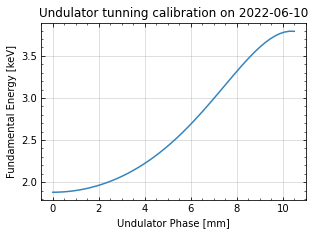

In [9]:
### create a list of phase values
phase_values = np.linspace(0, 10.5, 51)

### the calibration is converted into a 8th degree fitted polynomial
poly_coefficients = get_manaca_poly_coefficients()

### use the coefficients to generate the calibrated function
fundamental_energies = poly_any_degree(phase_values, poly_coefficients)

plot_xy(phase_values, fundamental_energies,
       xlabel='Undulator Phase [mm]', ylabel='Fundamental Energy [keV]',
       title='Undulator tunning calibration on 2022-06-10')


# Image acquisition and processing related functions

In [10]:
def get_image_max_value(image_pv, shape=[1024, 1280, 1], 
                        binning=[1,1], plot_image=0):
    
    import epics
    
    ### read PVs
    img = np.array(epics.caget(image_pv))            # get image from pv
    img = img.reshape(shape[0], shape[1], shape[2])  # reshape array
    img = img[:,:,0]                                 # get the RGB channel
    
    ### bin image to avoid saturating noise
    if(binning != [1,1]):
        img = bin_matrix(img, binning[0], binning[1])
        
    ### get maximum value
    img_max = np.max(img)

    if(plot_image):
        fig, ax = plt.subplots(figsize=(12,8))
        im = ax.imshow(img, origin='lower')
        fig.colorbar(im, ax=ax)
        plt.show()
    
    return img_max

def adjust_exposure_time(image_pv, exp_time_pv, saturation=256, 
                         threshold=[0.75, 0.85], shape=[1024, 1280, 1], 
                         binning=[1,1], exp_time_max=1, debug=0):
    
    #import epics
    
    img_max = get_image_max_value(image_pv, shape, binning)
    
    ### check if exposure time is ok
    exp_time_is_bad = ((img_max < threshold[0]*saturation) or  
                       (img_max > threshold[1]*saturation))

    exp_time = float(epics.caget(exp_time_pv))    
    
    ### optimize exposure time
    if(exp_time_is_bad):
        
        print("   exposure time is bad. trying to optimize... ")
        
 
        if(debug): print("   exposure time is ", round(exp_time, 3))
    
        trial_number = 0
        
        while exp_time_is_bad:
            
            trial_number += 1
            if(debug): print("   trial number is ", trial_number)
            
            # avoid infinite loops
            if trial_number > 20:
                if(debug): print('   failed to optimize exposure time')
                break
        
            img_max = get_image_max_value(image_pv, shape, binning)  
            if(debug): print('   image maximum is', round(img_max, 1))
        
            # if is saturated, divide time by 2
            if(img_max >= threshold[1]*saturation):
                exp_time = round(exp_time/2, 4)
                epics.caput(exp_time_pv, exp_time, wait=True)
                if(debug): print("   image saturated. changing exp time to ", exp_time)
                time.sleep(2*exp_time)
                
            # if exposure time is too low, estimate the ideal value
            elif(img_max <= threshold[0]*saturation):
                if(img_max >= saturation*0.05):
                    #increase_factor = np.mean(threshold)*saturation / img_max
                    increase_factor = 1.2
                else:
                    increase_factor = 2.0
                
                exp_time = round(exp_time * increase_factor, 4)
                
                ## only increase if it is less than maximum allowed time
                if(exp_time <= exp_time_max):
                
                    epics.caput(exp_time_pv, exp_time, wait=True)
                    if(debug): print("   image underexposed. changing exp time to ", exp_time)
                    time.sleep(2*exp_time)
                    
                else:
                    print('   calculated exposition time larger than allowed. Optimization Failed')
                    epics.caput(exp_time_pv, exp_time_max, wait=True)
                    time.sleep(2*exp_time_max)
                    break
                
                
            # else, exposure time is ok
            else:
                exp_time_is_bad = False
                print("   exp time set to {0:.3f} . max value = {1:.1f}".format(exp_time, img_max) + " optimization was successful. \n")
        
        return exp_time
    
    else:
        print('   no need to optimize exposure time')
        return exp_time




def bin_matrix(matrix, binning_y, binning_x):

    yn, xn = matrix.shape

    if ((xn % binning_x != 0) or (yn % binning_y != 0)):
        print('array of shape ({0} x {1}) cannot be binned by factor ({2},{3})'.format(yn, xn, binning_y, binning_x))
        return matrix
    
    else:
        #print('binning matrix of shape({0},{1}) by factors ({2},{3})'.format(yn, xn, binning_y, binning_x))
        xn = int(xn / binning_x)
        yn = int(yn / binning_y)
            
        matrix_binned = np.zeros((yn,xn), dtype=float)
        
        count_y = 0
        for iy in range(yn):
    
            count_x = 0
            for ix in range(xn):
                
                matrix_binned[iy,ix] = np.sum(matrix[count_y:count_y+binning_y,
                                                     count_x:count_x+binning_x])
    
                count_x += binning_x
            count_y += binning_y
            
        matrix_binned /= binning_x*binning_y
      
        if(0):
            fig, ax = plt.subplots(figsize=(12,4), ncols=2)
            im0 = ax[0].imshow(matrix, origin='lower')
            im1 = ax[1].imshow(matrix_binned, origin='lower')
            fig.colorbar(im0, ax=ax[0])
            fig.colorbar(im1, ax=ax[1])
        
            plt.show()
     
        return matrix_binned

def acquire_image(image_pv, shape=(1024,1280), binning=(1,1), plot_image=0):

    img = np.array(epics.caget(image_pv))
    img = img.reshape(shape)
    
    if(binning != (1,1)):
        img = bin_matrix(img, binning[0], binning[1])
    
    if(plot_image):
        fig, ax = plt.subplots(figsize=(6,4))
        im = ax.imshow(img, origin='lower', cmap='jet')
        fig.colorbar(im, ax=ax)
        plt.show()
        #plt.savefig(filename, dpi=400)
        #plt.close('all')
        
    return img


def get_centroid(img, x=0, y=0):
    
    shape = img.shape
    
    if(x==0):
        x = np.arange(0, shape[1])
    if(y==0):
        y = np.arange(0, shape[0])
    
    Ix = np.sum(img, axis=0)
    Iy = np.sum(img, axis=1)

    x_mean = 0
    y_mean = 0

    if(np.sum(Ix) != 0):
        x_mean = x[np.argmax(Ix)]

    if(np.sum(Iy) != 0):
        y_mean = y[np.argmax(Iy)]  
        
    return (y_mean, x_mean)

def get_vertical_cut(img, x=0, nx=1, binning=(1,1), plot_cut=0):
    
    if(binning != (1,1)):
        img = bin_matrix(img, binning[0], binning[1])
    
    if(nx == 1):
        xmin=int(x)

    elif(nx > 1):
        xmin=int(x - nx/2)

    xmax=int(xmin + nx)
        
    cut = np.sum(img[:, xmin:xmax], axis=1)/nx
    
    if(plot_cut):
        plt.figure()
        plt.plot(cut)
        plt.show()
    
    return cut
    
    

def define_ROI(pv_prefix='MNC:A:BASLER02', ROI_shape=(400,400), ROI_start=(0,0), ROI_binning=(1,1)):
    
    pv_image = pv_prefix + ':image1:ArrayData'
    
    # enable ROI
    epics.caput(pv_prefix +':ROI1:EnableCallbacks', 1, wait=True)
    epics.caput(pv_prefix + ':image1:NDArrayPort', 'ROI1', wait=True)
    
    # set ROI
    epics.caput(pv_prefix +':ROI1:MinX', ROI_start[1], wait=True)    
    epics.caput(pv_prefix +':ROI1:MinY', ROI_start[0], wait=True)
    
    epics.caput(pv_prefix +':ROI1:SizeX', ROI_shape[1], wait=True)    
    epics.caput(pv_prefix +':ROI1:SizeY', ROI_shape[0], wait=True)
    
    epics.caput(pv_prefix +':ROI1:BinX', ROI_binning[1], wait=True)    
    epics.caput(pv_prefix +':ROI1:BinY', ROI_binning[0], wait=True)
    
    time.sleep(1)

def initialize_hdf5(h5_filename):
    
    with h5py.File(h5_filename, 'w') as f:
        
        f.attrs['begin time'] = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        f.create_group('images')
        f.create_group('vertical_cuts')
    
def end_hdf5(h5_filename):
    
    with h5py.File(h5_filename, 'a') as f:
        f.attrs['end time'] = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        
    
def create_group(h5_filename, group_name, group_attributes):
    
    with h5py.File(h5_filename, 'a') as f:
        group_images = f['images'].create_group(group_name)
        group_cuts = f['vertical_cuts'].create_group(group_name)
        
        for i in range(len(group_attributes)):
            group_images.attrs[group_attributes[i][0]] = group_attributes[i][1]
            group_cuts.attrs[group_attributes[i][0]] = group_attributes[i][1]
    
def append_image_to_hdf5(h5_filename, group_name, dataset_name, image, attributes):
    
    with h5py.File(h5_filename, 'a') as f:
        
        group = f['images/'+group_name]
        dset = group.create_dataset(dataset_name, data=image, compression="gzip")
        
        for i in range(len(attributes)):
            dset.attrs[attributes[i][0]] = attributes[i][1] 

def append_cut_to_hdf5(h5_filename, group_name, dataset_name, cut, attributes):
    
    with h5py.File(h5_filename, 'a') as f:
                
        group = f['vertical_cuts/'+group_name]
        dset = group.create_dataset(dataset_name, data=cut, compression="gzip")
        
        for i in range(len(attributes)):
            dset.attrs[attributes[i][0]] = attributes[i][1] 
            

    
    

# Define ROI

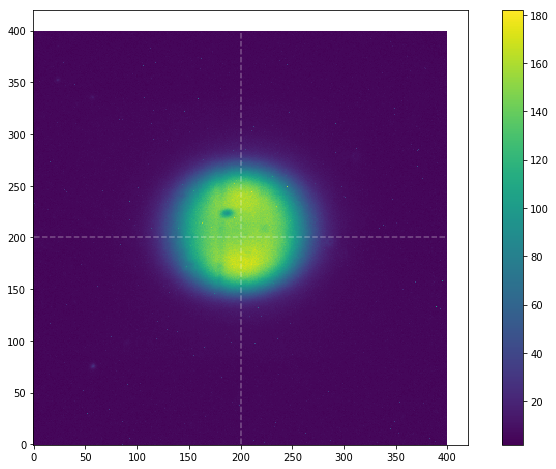

In [17]:
# roi_shape = (1024,1280)
# roi_start = (0,0)

roi_shape = (400,400)
roi_start = (32,860)

define_ROI(pv_prefix='MNC:A:BASLER03', ROI_shape=roi_shape, ROI_start=roi_start, ROI_binning=(1,1))
    
pv_DVF_image = pv_DVF3_image


img = np.array(epics.caget(pv_DVF_image))
img = img.reshape(roi_shape)

fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(img, cmap='viridis', origin='lower')
fig.colorbar(im, ax=ax)
ax.vlines(x=200, ymin=0, ymax=400, color='w', linestyle='--', alpha=0.3)
ax.hlines(y=200, xmin=0, xmax=400, color='w', linestyle='--', alpha=0.3)

# np.savetxt('/home/ABTLUS/xafs/data/2021-03-27/DVF3_dark_field_39p8mA_010ms_no_led.txt', img)


# Define Scan Points

In [18]:
energy_points = np.linspace(5.62, 18.0, 11)

energy_points = energy_points[:8]

min_energy1 = 1.870
max_energy1 = 3.600

energy_scan_points = find_harmonics_given_energy(np.round(energy_points, 3), min_energy1, max_energy1, print_points=0)

###### Find phase values

scan_points = []

for i in range(len(energy_scan_points)):
    
    energy_value, harmonic = energy_scan_points[i]
    
#     energy_1st_harmonic = energy_value / harmonic
    phase = get_phase_from_energy(energy_value, harmonic, verbose=0)
    point_to_scan = [energy_value, phase, harmonic]
    scan_points.append(point_to_scan)

    if(1):
        print(point_to_scan)

# scan_points = scan_points[::-1]
            
print("total number of points to scan is", len(scan_points))

##### shuffle points

# random.shuffle(scan_points)
# for point in scan_points:
#     print(point)


[5.62, 0.0, 3]
[6.858, 4.324, 3]
[8.096, 6.027, 3]
[9.334, 7.357, 3]
[10.572, 8.667, 3]
[10.572, 3.32, 5]
[11.81, 4.692, 5]
[13.048, 5.707, 5]
[14.286, 6.56, 5]
[14.286, 2.765, 7]
total number of points to scan is 10


In [39]:
np.linspace(-0.06, 0.06, 13)

array([-0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,
        0.03,  0.04,  0.05,  0.06])

# 2. Start Scan 

In [19]:

time_str = time.strftime("%Y-%m-%d_%Hh%Mm%Ss", time.localtime())
h5_filename  = '/home/ABTLUS/xafs/data/2021-03-27/'
h5_filename += 'MAN_emit_scan_5mA_' + time_str + '.h5'

initialize_hdf5(h5_filename)

delta_energy_array = np.linspace(-0.06, 0.06, 13)
delta_DCM = 0.5e-3
img_shape = [roi_shape[0], roi_shape[1], 1]


for i in range(len(scan_points)):

    ############################################
    ## do caputs
       
    DCM_value, UND_value, harmonic = scan_points[i]
    #DCM_value += delta_energy_array[0]
    
    print('\n')
    print('Moving... step {0} out of {1}'.format(i+1, len(scan_points)))
    print('DCM Energy = {0:.3f} keV at harmonic {1}'.format(DCM_value, harmonic))
    print('UND Phase = {0:.3f} mm'.format(UND_value))

    if(1):

        put_undulator(UND_value, pv_und_phase_write, pv_und_phase_start)

        put_DCM(DCM_value, pv_DCM_energy_write, pv_DCM_trajMove)

        print('waiting...')
        
        t0 = time.time()
        moving = 1
        while moving:
            time.sleep(0.1)
            DCM_diff = np.abs(epics.caget(pv_DCM_energy_read) - DCM_value)
            DCM_moving = DCM_diff >= delta_DCM
            UND_moving = epics.caget(pv_und_phase_moving)
            moving = UND_moving or DCM_moving

            if(time.time() - t0 > 10):
                put_DCM(DCM_value, pv_DCM_energy_write, pv_DCM_trajMove)
                t0 = time.time()

        print('finished moving!')

        time.sleep(0.5)

    if(1):
        print('starting acquisition...')
        
        group_name = 'E_{0:.3f}keV_z_{1:.3f}mm'.format(scan_points[i][0], UND_value)
        
        group_attributes = []
        group_attributes.append(['DCM Central Energy', scan_points[i][0]])
        group_attributes.append(['Undulator Phase', UND_value])
        group_attributes.append(['Harmonic', harmonic])
        
        create_group(h5_filename, group_name, group_attributes)
        
        exp_time = adjust_exposure_time(pv_DVF3_image, pv_DVF3_exp_time, saturation=2**8, 
                                        threshold=[0.7, 0.85], shape=img_shape, 
                                        binning=[4,4], exp_time_max=1.1, debug=0)

        time.sleep(0.5)
        #nput('PRESS ANY BUTTON')

        #### scan energies around central energy
        for j, delta_energy in enumerate(delta_energy_array):
        
            DCM_value_new = DCM_value + delta_energy

            put_DCM(DCM_value_new, pv_DCM_energy_write, pv_DCM_trajMove)

            print('     waiting... DCM going to {0:.3f}'.format(DCM_value_new))

            t0 = time.time()
            moving = 1
            while moving:
                time.sleep(0.1)
                DCM_diff = np.abs(epics.caget(pv_DCM_energy_read) - DCM_value_new)
                DCM_moving = DCM_diff >= delta_DCM
                moving = DCM_moving 

                if(time.time() - t0 > 5):
                    put_DCM(DCM_value_new, pv_DCM_energy_write, pv_DCM_trajMove)
                    t0 = time.time()

            time.sleep(0.5)
                    
            print('     acquiring...')
            acquisition_time = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())
            current = get_current_value()
            
            ### acquire image 
            img = acquire_image(pv_DVF3_image, roi_shape)
            img_sum = np.sum(img)

            ### get centroid
            centroid_y, centroid_x = get_centroid(img)
            
           
            img_attributes = []
            #img_attributes.append(['Undulator Phase', UND_value])
            img_attributes.append(['DCM Energy', DCM_value_new])
            img_attributes.append(['Integral', img_sum])
            img_attributes.append(['Current', current])
            img_attributes.append(['CentroidX', centroid_x])
            img_attributes.append(['CentroidY', centroid_y])
            img_attributes.append(['Acquisition Time', acquisition_time])
            img_attributes.append(['Exposure Time', exp_time])
            
            dataset_name = 'E_{0:.3f}keV'.format(DCM_value_new)
            append_image_to_hdf5(h5_filename, group_name, dataset_name, img, img_attributes)
            
            if(1):
                ### do a vertical cut
                cut_binning = 4
                cut = get_vertical_cut(img, x=centroid_x, nx=10, binning=(cut_binning,1))

                ### get fwhm value
                fwhm_pts = get_fwhm(np.arange(0, int(roi_shape[0]/cut_binning)), cut, 
                                    inmost_outmost=1, oversampling=200)
                fwhm = fwhm_pts[0] * cut_binning

                cut_attributes = []
                cut_attributes.append(['FWHM', fwhm])

                append_cut_to_hdf5(h5_filename, group_name, dataset_name, cut, cut_attributes)
            
        if(i == len(scan_points) - 1):
            end_hdf5(h5_filename)
    

print("FINISHED!!")
    
    
    




Moving... step 1 out of 10
DCM Energy = 5.620 keV at harmonic 3
UND Phase = 0.000 mm
waiting...
finished moving!
starting acquisition...
   exposure time is bad. trying to optimize... 
   calculated exposition time larger than allowed. Optimization Failed
     waiting... DCM going to 5.560
     acquiring...
     waiting... DCM going to 5.570
     acquiring...
     waiting... DCM going to 5.580
     acquiring...
     waiting... DCM going to 5.590
     acquiring...
     waiting... DCM going to 5.600
     acquiring...
     waiting... DCM going to 5.610
     acquiring...
     waiting... DCM going to 5.620
     acquiring...
     waiting... DCM going to 5.630
     acquiring...
     waiting... DCM going to 5.640
     acquiring...
     waiting... DCM going to 5.650
     acquiring...
     waiting... DCM going to 5.660
     acquiring...
     waiting... DCM going to 5.670
     acquiring...
     waiting... DCM going to 5.680
     acquiring...


Moving... step 2 out of 10
DCM Energy = 6.858 keV a

     acquiring...
     waiting... DCM going to 14.286
     acquiring...
     waiting... DCM going to 14.296
     acquiring...
     waiting... DCM going to 14.306
     acquiring...
     waiting... DCM going to 14.316
     acquiring...
     waiting... DCM going to 14.326
     acquiring...
     waiting... DCM going to 14.336
     acquiring...
     waiting... DCM going to 14.346
     acquiring...


Moving... step 10 out of 10
DCM Energy = 14.286 keV at harmonic 7
UND Phase = 2.765 mm
waiting...
finished moving!
starting acquisition...
   exposure time is bad. trying to optimize... 
   calculated exposition time larger than allowed. Optimization Failed
     waiting... DCM going to 14.226
     acquiring...
     waiting... DCM going to 14.236
     acquiring...
     waiting... DCM going to 14.246
     acquiring...
     waiting... DCM going to 14.256
     acquiring...
     waiting... DCM going to 14.266
     acquiring...
     waiting... DCM going to 14.276
     acquiring...
     waiting... DCM 

## Tests

In [19]:
aquire_image(pv_DVF2_image, shape=(1024,1280), filename=prefix)

In [ ]:
array([ 1.87023258e+00, -2.28529023e-03,  2.00948508e-02,  2.49778389e-03,
       -1.32115446e-03,  3.25708366e-04, -3.73207112e-05,  1.96384705e-06,
       -4.24686251e-08])

In [64]:
put_DCM(9.1, pv_DCM_energy_write, pv_DCM_trajMove)

In [68]:
put_undulator(11.0, pv_und_phase_write, pv_und_phase_start)

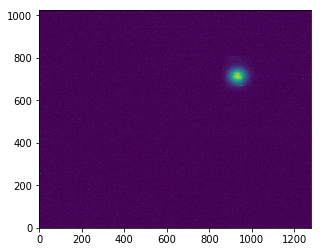

In [72]:
img = np.array(epics.caget(pv_DVF2_image))

img = img.reshape((1024,1280))

plt.figure()
plt.imshow(img, origin='lower')


In [7]:
epics.caput(pv_DVF2_exp_time, 0.02 * 1e6)


1

In [8]:
epics.caget(pv_DVF2_exp_time)

20000

In [102]:
adjust_exposure_time(pv_DVF2_image, pv_DVF2_exp_time, saturation=2**16, 
                         threshold=[0.7, 0.9], shape=[1024, 1280, 1], 
                         binning=[4,4], exp_time_max=1.1, debug=0)


   exposure time is bad. trying to optimize... 

   calculated exposition time larger than allowed. Optimization Failed


1.29

65536

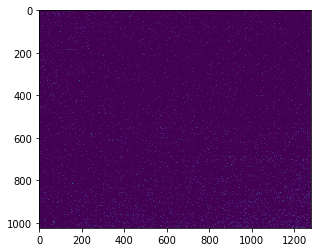

In [6]:
pv_DVF2_image = 'MNC:A:BASLER02:image1:ArrayData'


img = np.array(epics.caget(pv_DVF2_image))
#img = img.reshape((294, 400))
img = img.reshape((1024, 1280))

plt.figure()
plt.imshow(img)



In [10]:
epics.caput('MNC:A:BASLER02:image1:NDArrayPort', 'ROI1')

1

In [12]:
epics.caget('MNC:A:BASLER02:image1:ArraySize0_RBV')

0

In [15]:
epics.caget('MNC:A:BASLER02:cam1:ArraySizeX_RBV')
epics.caget('MNC:A:BASLER02:cam1:ArraySizeY_RBV')
epics.caget('MNC:A:BASLER02:cam1:ArraySizeZ_RBV')

0

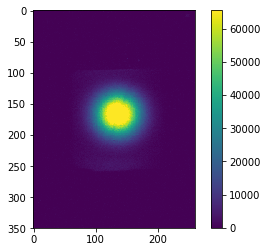

In [28]:

    
#     ny = epics.caget('MNC:A:BASLER02:image1:ArraySize0_RBV')
#     nx = epics.caget('MNC:A:BASLER02:image1:ArraySize1_RBV')



    
    

In [38]:
image_pv = 'MNC:A:BASLER02:image1:ArrayData'
exp_time_pv = 'MNC:A:BASLER02:cam1:AcquireTime'

shape = [roi_shape[0], roi_shape[1], 1]

adjust_exposure_time(image_pv, exp_time_pv, saturation=2**16, 
                     threshold=[0.4, 0.7], shape=shape, 
                     binning=[1,1], exp_time_max=1, debug=1)


   exposure time is bad. trying to optimize... 

   exposure time is  0.01
   trial number is  1
   image maximum is 65472
   image saturated. changing exp time to  0.005
   trial number is  2
   image maximum is 65472
   image saturated. changing exp time to  0.0025
   trial number is  3
   image maximum is 45376
   exp time set to 0.003 . max value = 45376.0 optimization was successful. 



45376

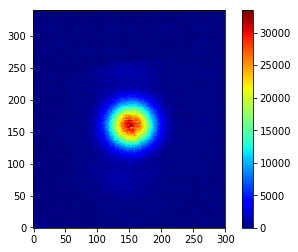

162 152


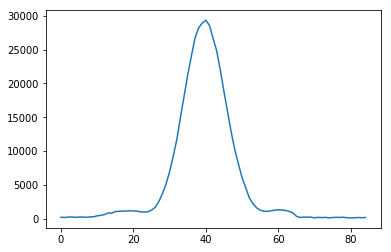

In [8]:
img = acquire_image(pv_DVF2_image, roi_shape, binning=(1,1), plot_image=1)

centroid_y, centroid_x = get_centroid(img)
print(centroid_y, centroid_x)
cut_binning = 4
cut = get_vertical_cut(img, x=centroid_x, nx=20, binning=(cut_binning,1), plot_cut=1)
fwhm_pts = get_fwhm(np.arange(0, int(roi_shape[0]/cut_binning)), cut)
fwhm = fwhm_pts[0] * cut_binning

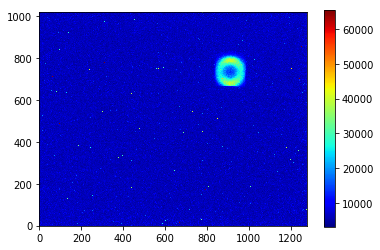

779 939


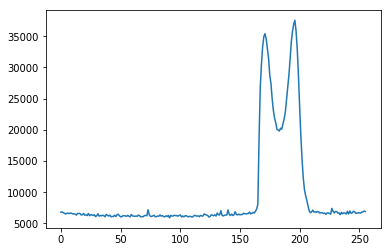

256


KeyError: "Unable to open object (object 'vertical_cuts' doesn't exist)"

In [107]:
filename00 = 'SCAN1_2020-12-09_19-26-14.h5'

img = acquire_image(pv_DVF2_image, [1024,1280], binning=(1,1), plot_image=1)

centroid_y, centroid_x = get_centroid(img)
print(centroid_y, centroid_x)
cut_binning = 4
cut = get_vertical_cut(img, x=centroid_x, nx=20, binning=(cut_binning,1), plot_cut=1)
print(len(cut))
fwhm_pts = get_fwhm(np.arange(0, int(1024/cut_binning)), cut)
fwhm = fwhm_pts[0] * cut_binning

attributes = [['laaaa', 2], ['bshsb', 454]]
gname='ushd'
dname='uhuhuh'
append_image_to_hdf5(h5_filename, gname, dname, img, attributes, attributes)

append_cut_to_hdf5(h5_filename, gname, dname, cut, attributes, attributes)

